In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


def plot_km(surv_data, survival_clm="Survival_in_days", group_clm=None, conf = False):

    if group_clm is None:
        time, survival_prob, conf_int = kaplan_meier_estimator(
            surv_data["Status"], surv_data[survival_clm], conf_type="log-log"
        )

        plt.step(time, survival_prob, where="post")
        if conf:
            plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    else:
        for group_type in np.unique(surv_data[group_clm]):
            mask = surv_data[group_clm] == group_type
            time_treatment, survival_prob_treatment, conf_int = kaplan_meier_estimator(
                surv_data["Status"][mask],
                surv_data[survival_clm][mask],
                conf_type="log-log",
            )

            plt.step(
                time_treatment,
                survival_prob_treatment,
                where="post",
                label=f"{group_type}",
            )
            plt.legend(loc="best")

            if conf:
                plt.fill_between(
                    time_treatment, conf_int[0], conf_int[1], alpha=0.25, step="post"
                )
    plt.ylim(0, 1)
    plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")

from utils.plots import get_chisq

In [2]:
surv_data = pd.read_csv("./data/MoGCN_data/gt_data.csv")
surv_data

,Sample_ID,class,Pam50 Subtype,Status,Survival_in_days,Strat_ID
0,A1-A0SF,0,LumA,False,1463,LumA_0
1,A1-A0SJ,0,LumA,False,416,LumA_0
2,A1-A0SK,2,Basal,True,967,Basal_1
3,A1-A0SO,2,Basal,False,852,Basal_0
4,A1-A0SQ,0,LumA,False,554,LumA_0
...,...,...,...,...,...,...
498,GM-A2DM,0,LumA,False,3226,LumA_0
499,GM-A2DN,0,LumA,False,3091,LumA_0
500,GM-A2DO,1,LumB,False,2596,LumB_0
501,GM-A3NY,0,LumA,False,1162,LumA_0


#### KM plots

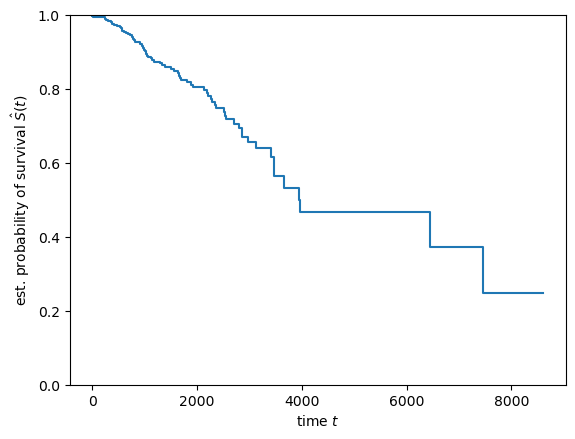

In [11]:
plot_km(surv_data, survival_clm="Survival_in_days")

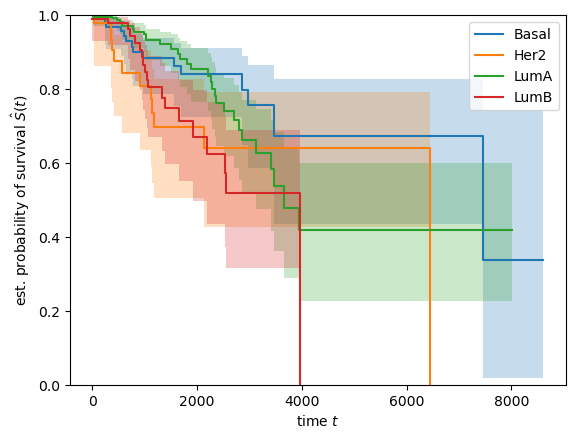

In [3]:
plot_km(surv_data, group_clm="Pam50 Subtype", conf=True)

#### Chi-square

In [4]:
get_chisq(surv_data, surv_data["Pam50 Subtype"])

(11.499351091978287, 0.009310591664479737)

# Results

In [27]:
def combine_results(path, ids):

    metrics = None
    for id in exp_ids:
        temp = pd.read_csv(os.path.join(path_results, f"{id}/test/","metrics.csv"))
        temp["model"] = id
        
        if metrics is None:
            metrics = temp
        else:
            metrics = pd.concat([metrics,temp], ignore_index=True)

    metrics.set_index(metrics["model"], drop=True,  inplace = True)
    metrics = metrics.drop(columns=["model"])
    
    return metrics

exp_ids = ["cls_mlp", "cls_gcn", "cls_gat"]
path_results = f"./baseline_results/"

cls = combine_results(path_results, exp_ids)
cls

,acc,f1,chisqr,p_value,c_index
model,,,,,
cls_mlp,0.871287,0.859168,11.282398,0.010293,NaN
cls_gcn,0.891089,0.886530,13.085267,0.004456,NaN
cls_gat,0.831683,0.818839,12.053609,0.007202,NaN


In [29]:
exp_ids = ["surv_mlp", "surv_gcn", "surv_gat"]
path_resutls = f"./baseline_results/{id}/test/"

surv = combine_results(path_resutls, exp_ids)
surv

,acc,f1,chisqr,p_value,c_index
model,,,,,
surv_mlp,NaN,NaN,NaN,NaN,0.797386
surv_gcn,NaN,NaN,NaN,NaN,0.619826
surv_gat,NaN,NaN,NaN,NaN,0.641612


In [32]:
# exp_ids = ["mt_mlp", "mt_gcn", "mt_gat"]
exp_ids = ["mt_mlp"]
path_resutls = f"./baseline_results/{id}/test/"

surv = combine_results(path_resutls, exp_ids)
surv

,acc,f1,chisqr,p_value,c_index
model,,,,,
mt_mlp,0.920792,0.919733,11.413853,0.009686,0.766885


# Predictions

In [1]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
import numpy as np

from sksurv.preprocessing import OneHotEncoder



def get_c_index(data_x, data_y, estimator=CoxPHSurvivalAnalysis()):
    set_config(display="text")  # displays text representation of estimators

    estimator.fit(data_x, data_y)

    coef = pd.Series(estimator.coef_, index=data_x.columns)
    c_index = estimator.score(data_x, data_y)
    print("\nC-index: ", c_index)
    return c_index, coef

def get_score_features(x, y, m=CoxPHSurvivalAnalysis()):
    X = x.values
    n_features = X.shape[1]
    scores = np.empty(n_features)

    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    
    scores = pd.Series(scores, index=x.columns).sort_values(ascending=False)
    print("\nFeature scores:\n", scores)
    return scores

In [2]:
data_x = pd.read_csv("./data/MoGCN_results/latent_data.csv")
data_x = data_x.loc[data_x["Sample"].isin(surv_data["Sample_ID"])]
data_x = data_x.iloc[:,1:]
data_x

NameError: name 'pd' is not defined

In [3]:
def get_bool_mask(df_gt, df_ids):
    return np.array(df_gt["Sample_ID"].isin(df_ids))

train_mask = get_bool_mask(surv_data, pd.read_csv("./data/MoGCN_data/train_stratified.csv")["Sample_ID"])
test_mask = get_bool_mask(surv_data, pd.read_csv("./data/MoGCN_data/test_stratified.csv")["Sample_ID"])

NameError: name 'surv_data' is not defined

In [44]:
data_y = surv_data[["Status", "Survival_in_days"]].to_records(index=False)

estimator=CoxPHSurvivalAnalysis()
estimator.fit(data_x[train_mask], data_y[train_mask])

c_index = estimator.score(data_x[test_mask], data_y[test_mask])
print("\nC-index: ", c_index)



C-index:  0.5292682926829269
